# gan
- gan, cgan
- pix2pix

- 숫자 이미지 생성
- 채색

## cGAN
- Conditional Generative Adversarial Nets (cGAN)은 내가 원하는 종류의 이미지를 생성하고자 할 때 GAN이 가진 생성 과정의 불편함을 해소하여,
내가 원하는 종류의 이미지를 생성할 수 있도록 고안된 방법

![](https://aiffelstaticprd.blob.core.windows.net/media/images/cgan_img.max-800x600.png)

## data import
```
 pip install tensorflow-datasets
    ```

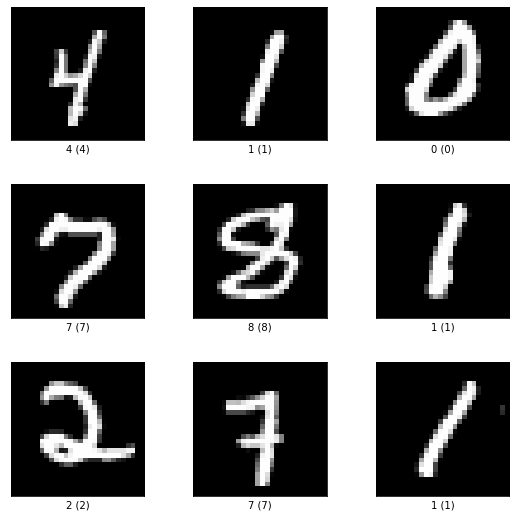

In [2]:
# mnist data set

import tensorflow_datasets as tfds

mnist, info =  tfds.load(
    "mnist", split="train", with_info=True
)

fig = tfds.show_examples(mnist, info)

In [3]:
## data set gan / cgan 용 분리
import tensorflow as tf

BATCH_SIZE = 128

def gan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1 # 256  1 ~ -1로 값 조정.
    return image

def cgan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    
    label = tf.one_hot(data["label"], 10) # one hot  label< 적용 
    return image, label

gan_datasets = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)
print("✅")

✅


Label : tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0. 0.], shape=(10,), dtype=float32)
Image Min/Max : -1.0 1.0


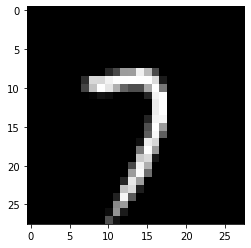

In [4]:
import matplotlib.pyplot as plt

for i,j in cgan_datasets : break

# 이미지 i와 라벨 j가 일치하는지 확인해 봅니다.     
print("Label :", j[0])
print("Image Min/Max :", i.numpy().min(), i.numpy().max())
plt.imshow(i.numpy()[0,...,0], plt.cm.gray)

# generator

## gan generator

In [5]:
from tensorflow.keras import layers, Input, Model

class GeneratorGAN(Model):
    def __init__(self):
        super(GeneratorGAN, self).__init__()

        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(256, activation='relu')
        self.dense_3 = layers.Dense(512, activation='relu')
        self.dense_4 = layers.Dense(28*28*1, activation='tanh')

        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise):
        out = self.dense_1(noise)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return self.reshape(out)

print("✅")

✅


## cgan generartor

In [6]:
class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        
        self.dense_z = layers.Dense(256, activation='relu')
        self.dense_y = layers.Dense(256, activation='relu')
        self.combined_dense = layers.Dense(512, activation='relu')
        self.final_dense = layers.Dense(28 * 28 * 1, activation='tanh')
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise, label):
        noise = self.dense_z(noise)
        label = self.dense_y(label)
        out = self.combined_dense(tf.concat([noise, label], axis=-1))
        out = self.final_dense(out)
        return self.reshape(out)
    
print("✅")

✅


# disicriminator

## gan discriminator

In [7]:
class DiscriminatorGAN(Model):
    def __init__(self):
        super(DiscriminatorGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.blocks = []
        for f in [512, 256, 128, 1]:
            self.blocks.append(
                layers.Dense(f, activation=None if f==1 else "relu")
            )
        
    def call(self, x):
        x = self.flatten(x) # fc layer 학습 시키기 위해...
        for block in self.blocks:
            x = block(x)
        return x
    
print("✅")

✅


## cGan disicriminator

- maxout : 두 레이어 사이를 연결할 때, 여러 개의 fully-connected 레이어를 통과시켜 그 중 가장 큰 값을 가져오도록
- 24-5

### mxaout

- units 차원의 representatoin을 pieces개만큼 만들고 그 중 최댓 값 1개 차원만 출력

In [10]:
class Maxout(layers.Layer):
    def __init__(self, units, pieces):
        super(Maxout, self).__init__()
        self.dense = layers.Dense(units*pieces, activation="relu")
        self.dropout = layers.Dropout(.5)    
        self.reshape = layers.Reshape((-1, pieces, units))
    
    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        x = self.reshape(x)
        return tf.math.reduce_max(x, axis=1)

print("✅")

✅


- cgan discriminator 는 maxout layer 활용

In [9]:
class DiscriminatorCGAN(Model):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.image_block = Maxout(240, 5)
        self.label_block = Maxout(50, 5)
        self.combine_block = Maxout(240, 4)
        
        self.dense = layers.Dense(1, activation=None)
    
    def call(self, image, label):
        image = self.flatten(image)
        image = self.image_block(image)
        label = self.label_block(label)
        x = layers.Concatenate()([image, label])
        x = self.combine_block(x)
        return self.dense(x)
    
print("✅")

✅


# GAN

## model set
- 찐, 짭 구별을 위해  Binary Cross Entropy를 사용
- adam optimizer이용

- 각 generator / disicirimnator 셋팅

In [27]:
from tensorflow.keras import optimizers, losses

bce = losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(fake_output), fake_output)

gene_opt = optimizers.Adam(1e-4)
disc_opt = optimizers.Adam(1e-4)    



In [28]:
# 노이즈를 100차원으로 설정
#

In [15]:
gan_generator = GeneratorGAN()
gan_discriminator = DiscriminatorGAN()

@tf.function()
def gan_step(real_images):
    noise = tf.random.normal([real_images.shape[0], 100])
    # 평균이 100인 이미지 사이즈의 랜덤 난수 생성,..........
    
    with tf.GradientTape(persistent=True) as tape:
        # Generator를 이용해 가짜 이미지 생성
        fake_images = gan_generator(noise)
        
        # Discriminator를 이용해 진짜 및 가짜이미지를 각각 판별
        real_out = gan_discriminator(real_images)
        fake_out = gan_discriminator(fake_images)
        
        # 각 손실을 계산
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
        
    # gradient 계산
    gene_grad = tape.gradient(gene_loss, gan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, gan_discriminator.trainable_variables)
    
    # 모델 학습
    gene_opt.apply_gradients(zip(gene_grad, gan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, gan_discriminator.trainable_variables))
    
    return gene_loss, disc_loss

print("✅")

✅


## train

In [16]:
EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    for i, images in enumerate(gan_datasets):
        gene_loss, disc_loss = gan_step(images)

        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i+1} ITER] G:{gene_loss}, D:{disc_loss}")

[1/10 EPOCHS, 100 ITER] G:2.0261566638946533, D:0.1625804901123047
[1/10 EPOCHS, 200 ITER] G:2.359306573867798, D:0.1301679015159607
[1/10 EPOCHS, 300 ITER] G:2.708083152770996, D:0.19783420860767365
[1/10 EPOCHS, 400 ITER] G:2.505645751953125, D:0.2221212238073349
[2/10 EPOCHS, 100 ITER] G:3.4952468872070312, D:0.19303321838378906
[2/10 EPOCHS, 200 ITER] G:2.195979118347168, D:0.5582379102706909
[2/10 EPOCHS, 300 ITER] G:3.2661235332489014, D:0.08849233388900757
[2/10 EPOCHS, 400 ITER] G:2.209390878677368, D:0.4414266049861908
[3/10 EPOCHS, 100 ITER] G:2.8462486267089844, D:0.20330531895160675
[3/10 EPOCHS, 200 ITER] G:3.249974250793457, D:0.1444922238588333
[3/10 EPOCHS, 300 ITER] G:2.721902847290039, D:0.14960813522338867
[3/10 EPOCHS, 400 ITER] G:2.401064872741699, D:0.19288086891174316
[4/10 EPOCHS, 100 ITER] G:2.978290557861328, D:0.12894564867019653
[4/10 EPOCHS, 200 ITER] G:2.7710344791412354, D:0.26447558403015137
[4/10 EPOCHS, 300 ITER] G:4.329907417297363, D:0.07925748825073

## test

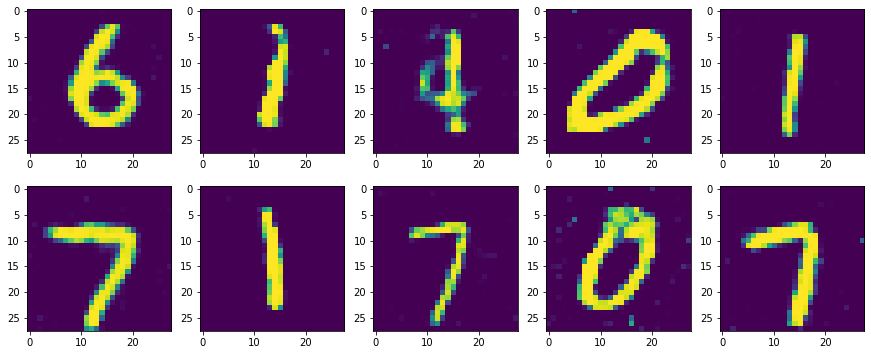

In [31]:
import numpy as np

noise = tf.random.normal([10, 100])

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

## epoch 500  weight

In [18]:
# 500 epch pretrained model upload
! wget https://aiffelstaticprd.blob.core.windows.net/media/documents/GAN_500.zip

--2020-11-05 10:58:52--  https://aiffelstaticprd.blob.core.windows.net/media/documents/GAN_500.zip
Resolving aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)... 52.239.148.4
접속 aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)|52.239.148.4|:443... 접속됨.
HTTP request sent, awaiting response... 200 OK
Length: 2151851 (2.1M) [application/zip]
Saving to: ‘GAN_500.zip’

GAN_500.zip         100%[===================>]   2.05M  2.90MB/s    in 0.7s    

2020-11-05 10:58:52 (2.90 MB/s) - ‘GAN_500.zip’ saved [2151851/2151851]



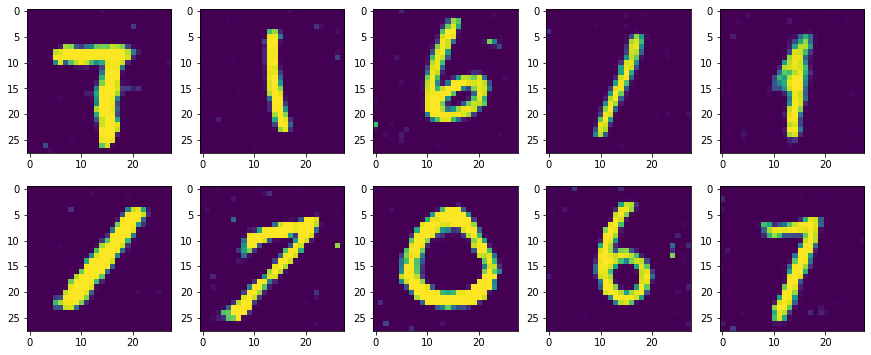

In [25]:
import os
weight_path = os.getenv('HOME')+'/aiffel/AIFFEL_LSG/lms/01-EXPLORATION/E24-gan_img/GAN_500/GAN_500'
#weight_path ='./GAN_500'

noise = tf.random.normal([10, 100]) 

gan_generator = GeneratorGAN()
gan_generator.load_weights(weight_path)

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

# CGAN

In [30]:
cgan_generator = GeneratorCGAN()
cgan_discriminator = DiscriminatorCGAN()

@tf.function()
def cgan_step(real_images, labels):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        fake_images = cgan_generator(noise, labels)
        
        real_out = cgan_discriminator(real_images, labels)
        fake_out = cgan_discriminator(fake_images, labels)
        
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    
    gene_grad = tape.gradient(gene_loss, cgan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, cgan_discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_grad, cgan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, cgan_discriminator.trainable_variables))
    return gene_loss, disc_loss


EPOCHS = 1
for epoch in range(1, EPOCHS+1):
    
    for i, (images, labels) in enumerate(cgan_datasets):
        gene_loss, disc_loss = cgan_step(images, labels)
    
        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i} ITER] G:{gene_loss}, D:{disc_loss}")

[1/1 EPOCHS, 99 ITER] G:1.4039404392242432, D:0.388755202293396
[1/1 EPOCHS, 199 ITER] G:1.9319370985031128, D:0.2703441381454468
[1/1 EPOCHS, 299 ITER] G:2.859206199645996, D:0.15383005142211914
[1/1 EPOCHS, 399 ITER] G:2.5274689197540283, D:0.1475595086812973


## epoch 500 weight upload

In [32]:
!wget https://aiffelstaticprd.blob.core.windows.net/media/documents/CGAN_500.zip
!unzip CGAN_500.zip

--2020-11-05 11:09:18--  https://aiffelstaticprd.blob.core.windows.net/media/documents/CGAN_500.zip
Resolving aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)... 52.239.148.4
접속 aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)|52.239.148.4|:443... 접속됨.
HTTP request sent, awaiting response... 200 OK
Length: 2579076 (2.5M) [application/zip]
Saving to: ‘CGAN_500.zip’

CGAN_500.zip        100%[===================>]   2.46M  3.51MB/s    in 0.7s    

2020-11-05 11:09:19 (3.51 MB/s) - ‘CGAN_500.zip’ saved [2579076/2579076]

Archive:  CGAN_500.zip
  inflating: CGAN_500.index          
  inflating: CGAN_500.data-00001-of-00002  
  inflating: CGAN_500.data-00000-of-00002  


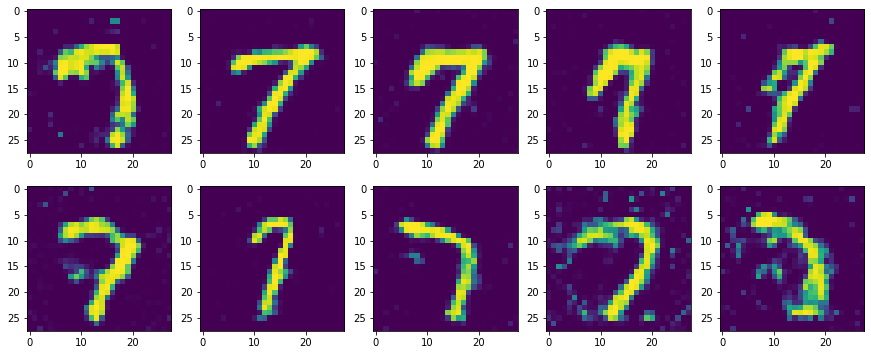

In [34]:
number =  7 # TODO : 생성할 숫자를 입력해 주세요!!

weight_path = os.getenv('HOME')+'/aiffel/AIFFEL_LSG/lms/01-EXPLORATION/E24-gan_img/CGAN/CGAN_500'

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

generator = GeneratorCGAN()
generator.load_weights(weight_path)

output = generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

# pix2pix_ generator
   
   
- conv 레이어를 통해 이미지 다운 샘플링 representation 학습 -bottleneck
- 다시 conv 레리어로 upsampling , 입력 이미지와 동일한 크기.로 생성.



![](https://aiffelstaticprd.blob.core.windows.net/media/images/p2p_generator.max-800x600.png)

## u-net

- skip connection
- 인토더의 상위 레이어의 결과를 decoder로 연결하여
- 비교적 선명한 결과를 얻을tn
![](https://aiffelstaticprd.blob.core.windows.net/media/images/p2p_generator_unet.max-800x600.png)

## PIX2PIX DISCRIMINATOR
- CONV LAYER   
![](https://aiffelstaticprd.blob.core.windows.net/media/original_images/dcgan_d.png)
![](https://aiffelstaticprd.blob.core.windows.net/media/images/patchgan.max-800x600.png)


- 파란색 점선은 여러 개의 출력 중 하나의 출력을 계산하기 위한 입력이미지의 receptive field 영역을 나타내고 있으며, 전체 영역을 다 보는 것이 아닌 일부 영역(파란색 점선)에 대해서만 진짜/가짜를 판별하는 하나의 확률 값을 도출
   
   
- 이미지의 일부 영역(patch)을 이용한다고 하여 PatchGAN
- 거리가 먼 두 픽셀은 서로 연관성이 거의 없기 때문에 특정 크기를 가진 일부 영역에 대해서 세부적으로 진짜/가짜를 판별하는 것

# 실습 채색

## Sketch2Pokemon DATA SET DONWLOAD
- https://www.kaggle.com/norod78/sketch2pokemon


In [38]:
!wget https://aiffelstaticprd.blob.core.windows.net/media/documents/sketch2pokemon.zip
!unzip sketch2pokemon.zip

--2020-11-05 12:14:03--  https://aiffelstaticprd.blob.core.windows.net/media/documents/sketch2pokemon.zip
Resolving aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)... 52.239.148.4
접속 aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)|52.239.148.4|:443... 접속됨.
HTTP request sent, awaiting response... 200 OK
Length: 66732281 (64M) [application/zip]
Saving to: ‘sketch2pokemon.zip’

sketch2pokemon.zip  100%[===================>]  63.64M  4.83MB/s    in 12s     

2020-11-05 12:14:16 (5.11 MB/s) - ‘sketch2pokemon.zip’ saved [66732281/66732281]

Archive:  sketch2pokemon.zip
   creating: pokemon_pix2pix_dataset/
   creating: pokemon_pix2pix_dataset/train/
  inflating: pokemon_pix2pix_dataset/train/0.jpg  
  inflating: pokemon_pix2pix_dataset/train/1.jpg  
  inflating: pokemon_pix2pix_dataset/train/10.jpg  
  inflating: pokemon_pix2pix_dataset/train/100.jpg  
  inflating: pokemon_pix2pix_dataset/train/101.jpg  
  inflating: pokemon_pix2pix

  inflating: pokemon_pix2pix_dataset/train/239.jpg  
  inflating: pokemon_pix2pix_dataset/train/24.jpg  
  inflating: pokemon_pix2pix_dataset/train/240.jpg  
  inflating: pokemon_pix2pix_dataset/train/241.jpg  
  inflating: pokemon_pix2pix_dataset/train/242.jpg  
  inflating: pokemon_pix2pix_dataset/train/243.jpg  
  inflating: pokemon_pix2pix_dataset/train/244.jpg  
  inflating: pokemon_pix2pix_dataset/train/245.jpg  
  inflating: pokemon_pix2pix_dataset/train/246.jpg  
  inflating: pokemon_pix2pix_dataset/train/247.jpg  
  inflating: pokemon_pix2pix_dataset/train/248.jpg  
  inflating: pokemon_pix2pix_dataset/train/249.jpg  
  inflating: pokemon_pix2pix_dataset/train/25.jpg  
  inflating: pokemon_pix2pix_dataset/train/250.jpg  
  inflating: pokemon_pix2pix_dataset/train/251.jpg  
  inflating: pokemon_pix2pix_dataset/train/252.jpg  
  inflating: pokemon_pix2pix_dataset/train/253.jpg  
  inflating: pokemon_pix2pix_dataset/train/254.jpg  
  inflating: pokemon_pix2pix_dataset/train/255.j

  inflating: pokemon_pix2pix_dataset/train/395.jpg  
  inflating: pokemon_pix2pix_dataset/train/396.jpg  
  inflating: pokemon_pix2pix_dataset/train/397.jpg  
  inflating: pokemon_pix2pix_dataset/train/398.jpg  
  inflating: pokemon_pix2pix_dataset/train/399.jpg  
  inflating: pokemon_pix2pix_dataset/train/4.jpg  
  inflating: pokemon_pix2pix_dataset/train/40.jpg  
  inflating: pokemon_pix2pix_dataset/train/400.jpg  
  inflating: pokemon_pix2pix_dataset/train/401.jpg  
  inflating: pokemon_pix2pix_dataset/train/402.jpg  
  inflating: pokemon_pix2pix_dataset/train/403.jpg  
  inflating: pokemon_pix2pix_dataset/train/404.jpg  
  inflating: pokemon_pix2pix_dataset/train/405.jpg  
  inflating: pokemon_pix2pix_dataset/train/406.jpg  
  inflating: pokemon_pix2pix_dataset/train/407.jpg  
  inflating: pokemon_pix2pix_dataset/train/408.jpg  
  inflating: pokemon_pix2pix_dataset/train/409.jpg  
  inflating: pokemon_pix2pix_dataset/train/41.jpg  
  inflating: pokemon_pix2pix_dataset/train/410.jpg

  inflating: pokemon_pix2pix_dataset/train/556.jpg  
  inflating: pokemon_pix2pix_dataset/train/557.jpg  
  inflating: pokemon_pix2pix_dataset/train/558.jpg  
  inflating: pokemon_pix2pix_dataset/train/559.jpg  
  inflating: pokemon_pix2pix_dataset/train/56.jpg  
  inflating: pokemon_pix2pix_dataset/train/560.jpg  
  inflating: pokemon_pix2pix_dataset/train/561.jpg  
  inflating: pokemon_pix2pix_dataset/train/562.jpg  
  inflating: pokemon_pix2pix_dataset/train/563.jpg  
  inflating: pokemon_pix2pix_dataset/train/564.jpg  
  inflating: pokemon_pix2pix_dataset/train/565.jpg  
  inflating: pokemon_pix2pix_dataset/train/566.jpg  
  inflating: pokemon_pix2pix_dataset/train/567.jpg  
  inflating: pokemon_pix2pix_dataset/train/568.jpg  
  inflating: pokemon_pix2pix_dataset/train/569.jpg  
  inflating: pokemon_pix2pix_dataset/train/57.jpg  
  inflating: pokemon_pix2pix_dataset/train/570.jpg  
  inflating: pokemon_pix2pix_dataset/train/571.jpg  
  inflating: pokemon_pix2pix_dataset/train/572.j

  inflating: pokemon_pix2pix_dataset/train/718.jpg  
  inflating: pokemon_pix2pix_dataset/train/719.jpg  
  inflating: pokemon_pix2pix_dataset/train/72.jpg  
  inflating: pokemon_pix2pix_dataset/train/720.jpg  
  inflating: pokemon_pix2pix_dataset/train/721.jpg  
  inflating: pokemon_pix2pix_dataset/train/722.jpg  
  inflating: pokemon_pix2pix_dataset/train/723.jpg  
  inflating: pokemon_pix2pix_dataset/train/724.jpg  
  inflating: pokemon_pix2pix_dataset/train/725.jpg  
  inflating: pokemon_pix2pix_dataset/train/726.jpg  
  inflating: pokemon_pix2pix_dataset/train/727.jpg  
  inflating: pokemon_pix2pix_dataset/train/728.jpg  
  inflating: pokemon_pix2pix_dataset/train/729.jpg  
  inflating: pokemon_pix2pix_dataset/train/73.jpg  
  inflating: pokemon_pix2pix_dataset/train/730.jpg  
  inflating: pokemon_pix2pix_dataset/train/731.jpg  
  inflating: pokemon_pix2pix_dataset/train/732.jpg  
  inflating: pokemon_pix2pix_dataset/train/733.jpg  
  inflating: pokemon_pix2pix_dataset/train/734.j

## DATA SET IMPORT

In [39]:
import os

data_path = os.getenv('HOME')+'/aiffel/AIFFEL_LSG/lms/01-EXPLORATION/E24-gan_img//pokemon_pix2pix_dataset/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 830


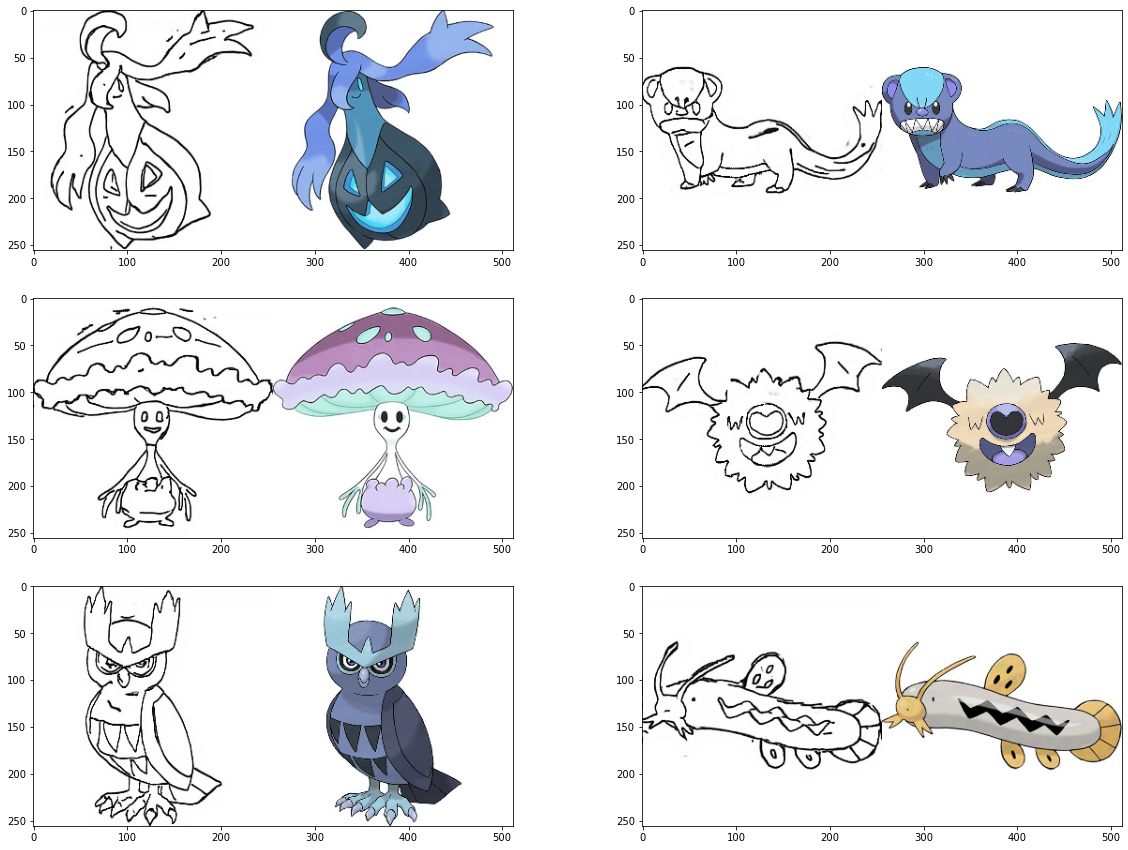

In [44]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

## IMG 처리

In [42]:
# 이미지 사이즈

In [41]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


## IMG 분리

In [ ]:
# 이미지 분할
# 반타작

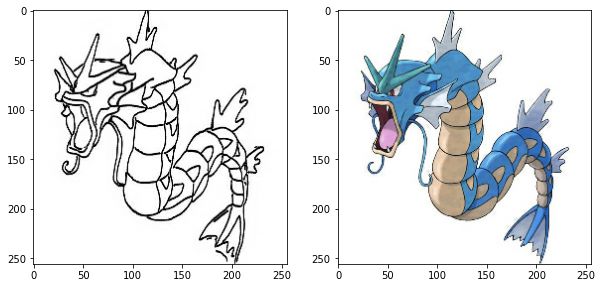

In [43]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

## AUGMENTATION 

In [46]:
# 자르고 위아래, 왼좌 전환, 

from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


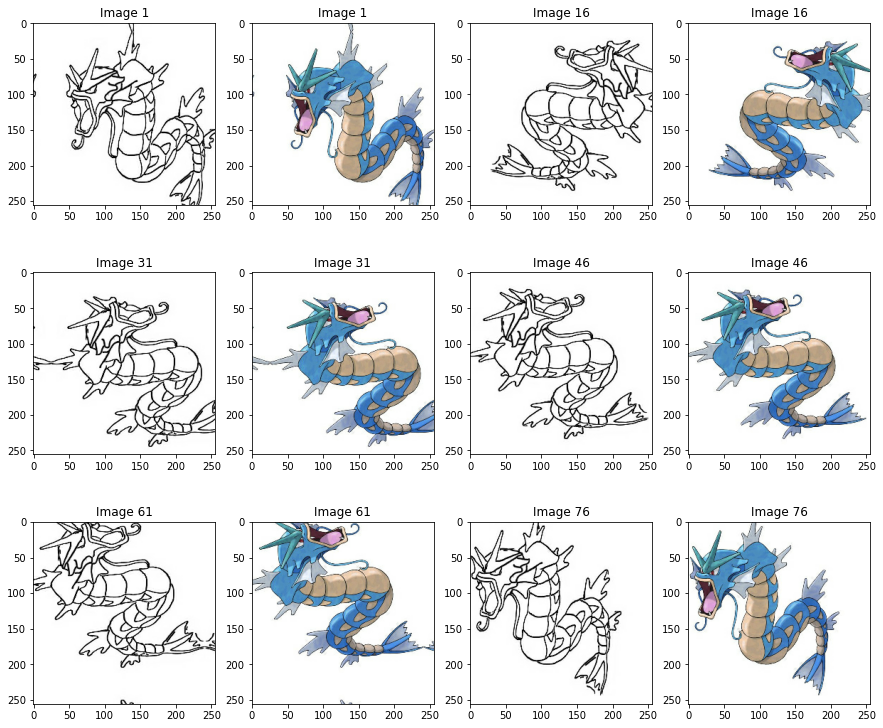

In [47]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 15

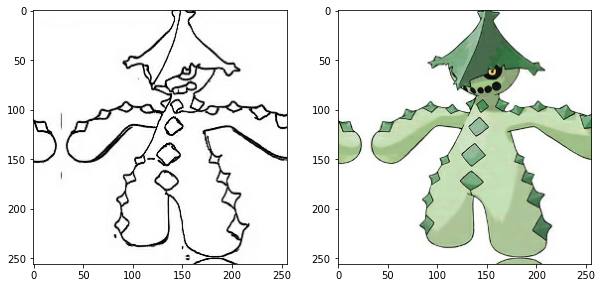

In [48]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

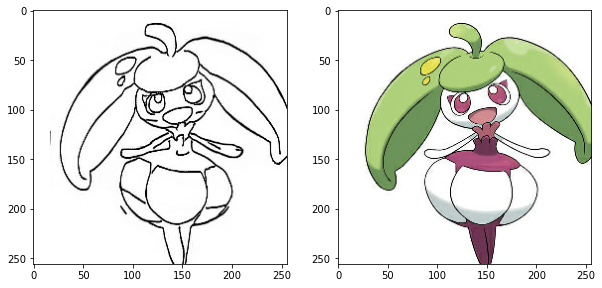

In [49]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## architecture

![](https://aiffelstaticprd.blob.core.windows.net/media/original_images/paper_g.png)

![](https://aiffelstaticprd.blob.core.windows.net/media/images/refer_g.max-800x600.png)

## generator_block ()


```
tf.keras.layers.Conv2D(
    filters, kernel_size, strides=(1, 1), padding='valid', data_format=None,
    dilation_rate=(1, 1), groups=1, activation=None, use_bias=True,
    kernel_initializer='glorot_uniform', bias_initializer='zeros',
    kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
    kernel_constraint=None, bias_constraint=None, **kwargs
)
```

In [51]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn: # encoder 첫번째 레이어 배치 놈 안씀.
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


In [52]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512] # 필터(커널) 개수 리스트)
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0: # 첫번째 레이어 배치놈 사용 안함(feat. 논문
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape # is used to instantiate a Keras tensor.
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [53]:
Encoder().get_summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)        

## decoder_bloack(

In [54]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("✅")

✅


In [55]:
Decoder().get_summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)      

## encoder+ decoder

In [56]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


## unet, (skip connection 추가)

### unet - generator

In [58]:
# 요건 그대로임

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


In [59]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1] # 
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [60]:
UNetGenerator().get_summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
_______________________________________________________________________________________

### unet - discriminator

In [61]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


In [62]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_45 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [63]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [64]:
Discriminator().get_summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]  

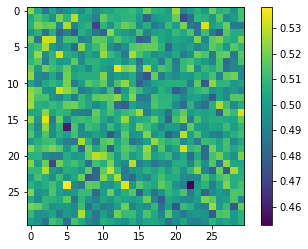

In [65]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

## train


In [68]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

# fake_disc는 Generator가 생성한 가짜 이미지를 Discriminator에 입력하여 얻어진 값
def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


In [67]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [69]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [70]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.9884                     
L1_loss:0.4773                     
Discriminator_loss:1.2629

EPOCH[1] - STEP[20]                     
Generator_loss:1.0375                     
L1_loss:0.3445                     
Discriminator_loss:1.1665

EPOCH[1] - STEP[30]                     
Generator_loss:1.1578                     
L1_loss:0.2960                     
Discriminator_loss:1.2079

EPOCH[1] - STEP[40]                     
Generator_loss:1.3927                     
L1_loss:0.2845                     
Discriminator_loss:0.8686

EPOCH[1] - STEP[50]                     
Generator_loss:1.4991                     
L1_loss:0.2369                     
Discriminator_loss:0.9883

EPOCH[1] - STEP[60]                     
Generator_loss:1.7020                     
L1_loss:0.2432                     
Discriminator_loss:0.7023

EPOCH[1] - STEP[70]                     
Generator_loss:1.9110                     
L1_loss:0.2532                    

EPOCH[3] - STEP[170]                     
Generator_loss:3.0349                     
L1_loss:0.3361                     
Discriminator_loss:0.1298

EPOCH[3] - STEP[180]                     
Generator_loss:1.0724                     
L1_loss:0.2834                     
Discriminator_loss:0.8524

EPOCH[3] - STEP[190]                     
Generator_loss:2.0565                     
L1_loss:0.2802                     
Discriminator_loss:0.2853

EPOCH[3] - STEP[200]                     
Generator_loss:2.0314                     
L1_loss:0.3568                     
Discriminator_loss:0.3809

EPOCH[4] - STEP[10]                     
Generator_loss:1.6269                     
L1_loss:0.2599                     
Discriminator_loss:0.3568

EPOCH[4] - STEP[20]                     
Generator_loss:1.3718                     
L1_loss:0.2253                     
Discriminator_loss:0.4039

EPOCH[4] - STEP[30]                     
Generator_loss:0.1075                     
L1_loss:0.2206                

EPOCH[6] - STEP[130]                     
Generator_loss:1.2030                     
L1_loss:0.2567                     
Discriminator_loss:0.8938

EPOCH[6] - STEP[140]                     
Generator_loss:1.3060                     
L1_loss:0.2362                     
Discriminator_loss:0.4383

EPOCH[6] - STEP[150]                     
Generator_loss:1.9522                     
L1_loss:0.2451                     
Discriminator_loss:0.8809

EPOCH[6] - STEP[160]                     
Generator_loss:3.2418                     
L1_loss:0.2713                     
Discriminator_loss:0.4242

EPOCH[6] - STEP[170]                     
Generator_loss:2.0224                     
L1_loss:0.2616                     
Discriminator_loss:0.2157

EPOCH[6] - STEP[180]                     
Generator_loss:1.1547                     
L1_loss:0.3087                     
Discriminator_loss:0.5538

EPOCH[6] - STEP[190]                     
Generator_loss:2.2839                     
L1_loss:0.2405             

EPOCH[9] - STEP[90]                     
Generator_loss:4.3513                     
L1_loss:0.2460                     
Discriminator_loss:2.6610

EPOCH[9] - STEP[100]                     
Generator_loss:2.0365                     
L1_loss:0.2472                     
Discriminator_loss:1.9182

EPOCH[9] - STEP[110]                     
Generator_loss:1.3503                     
L1_loss:0.2164                     
Discriminator_loss:0.4114

EPOCH[9] - STEP[120]                     
Generator_loss:0.9617                     
L1_loss:0.2517                     
Discriminator_loss:0.6335

EPOCH[9] - STEP[130]                     
Generator_loss:3.2211                     
L1_loss:0.2834                     
Discriminator_loss:0.1024

EPOCH[9] - STEP[140]                     
Generator_loss:3.5702                     
L1_loss:0.2484                     
Discriminator_loss:1.2632

EPOCH[9] - STEP[150]                     
Generator_loss:2.3340                     
L1_loss:0.2466              

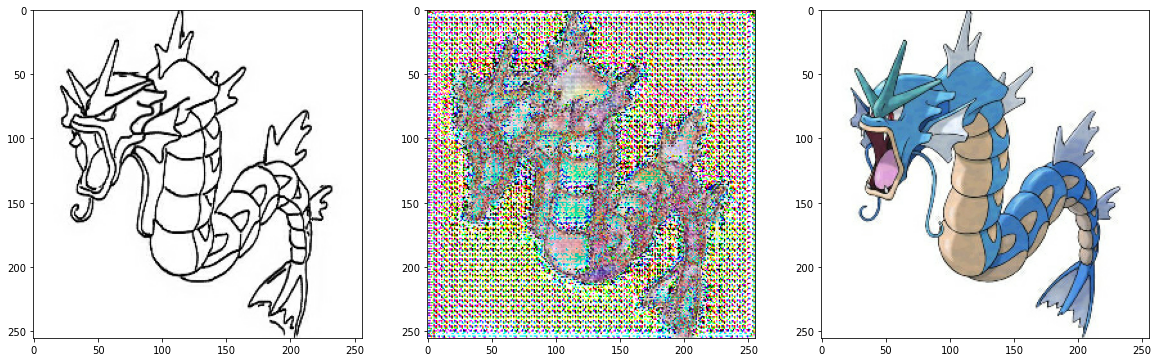

In [71]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

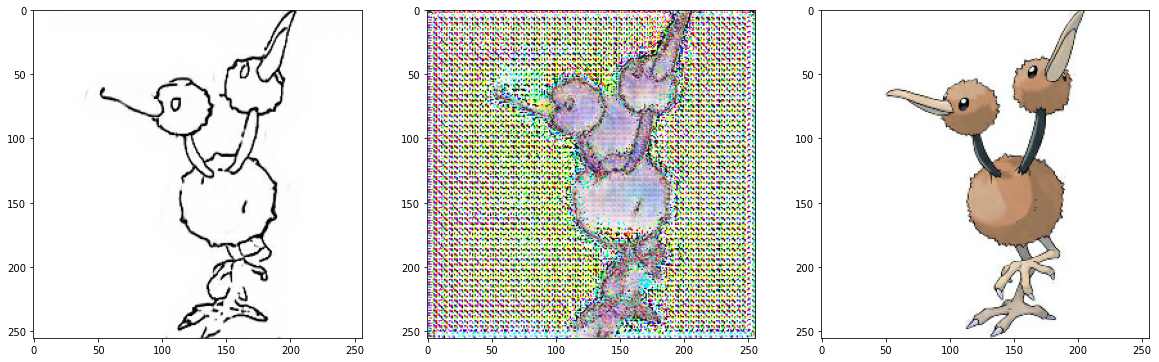

In [72]:
test_ind = 2

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))